In [1]:
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
import numpy as np

In [3]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const

In [4]:
from wolensing.plot.plot import plot_contour
import wolensing.amplification_factor.amplification_factor as af

In [5]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

coordinates in scaled units [x (radians) /thetaE_tot]

In [6]:
y0, y1 = 0.5, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [7]:
mL1 = 100

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE = param_processing(zL, zS, mL1)

In [8]:
beta0, beta1 = y0 * thetaE, y1 * thetaE
eta10, eta11 = 0 * l0 * thetaE, 0 * l1 * thetaE

In [9]:
lens_model_list = ['POINT_MASS']
kwargs_pm_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE}
kwargs_lens_list = [kwargs_pm_1]

In [10]:
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(eta10, eta11, kwargs_lens_list, beta0, beta1)#[0]
Tscale = 4 * (1 + zL) * mL1 * M_sun * G / c ** 3
print('T0 = {}'.format(T0))
print('Tscale = {}'.format(Tscale))

T0 = 57.68962732485115
Tscale = 0.0029552946153261453


In [14]:
kwargs_macro = {'source_pos_x': beta0,
                'source_pos_y': beta1,
                'theta_E': thetaE,
                'mu':1
               }

In [15]:
# Define the characteristic WindowSize
mL_ref = 10
thetaE_ref = param_processing(zL, zS, mL_ref)

kwargs_integrator = {'PixelNum': int(20000),          # Number of pixels on each side of the window
                     'PixelBlockMax': 2000,           # Dividing PixelNum into PixelBlock
                     'WindowSize': 210*thetaE_ref, 
                     'WindowCenterX': eta10, 
                     'WindowCenterY': eta11,
                     'T0': T0,                        # Time delay of the reference point (WindowCenter)
                     'TimeStep': 1e-5/Tscale,         # integration step in time domain
                     'TimeMax': T0 + 1/Tscale,        # Upper bound of time integration
                     'TimeMin': T0 - .1/Tscale,       # Lower bound of time integration
                     'TimeLength': 4/Tscale,          
                     'TExtend': 10/Tscale,            # Extend the time domain curve to desired time. In this example, it is extended to T0+10 seconds 
                     'Tscale': Tscale}                

start


Integrating...: 100%|██████████| 121/121 [00:33<00:00,  3.61it/s]


total time 13.99999


<Figure size 432x288 with 0 Axes>

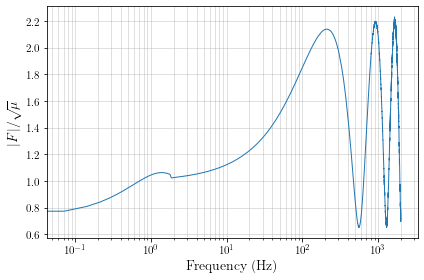

<AxesSubplot:xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [16]:
amplification = af.amplification_factor(lens_model_list=lens_model_list, kwargs_lens=kwargs_lens_list, kwargs_macro=kwargs_macro, **kwargs_integrator)
ts, F_tilde = amplification.integrator(gpu=False)
ws, Fws = amplification.fourier()
amplification.plot_freq()

In [18]:
from scipy.special import gamma, hyp1f1

In [19]:
y = 0.1
xm = (y+np.sqrt(y**22+4))/2
phim = (xm-y)**2 / 2 - np.log(xm)

In [21]:
f = np.linspace(0, 2000, 2000)
w = 8 * np.pi * (1.5 * 100) * f
F_ana = np.exp(np.pi * w/4 + (w/2)*(np.log(w/2)-2*phim) * 1j) * gamma(1-(w/2)* 1j) * hyp1f1((w/2)* 1j, 1, (w*y**2 /2)* 1j)

/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: ufunc 'hyp1f1' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [24]:
from lensinggw.solver.images import microimages
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
solver_kwargs = {'SearchWindowMacro': 10 * thetaE,
                 'SearchWindow': 5 * thetaE,
                 'OverlapDistMacro': 1e-17,
                 'OnlyMacro': True}
MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                     source_pos_y=beta1,
                                                     lens_model_list=lens_model_list,
                                                     kwargs_lens=kwargs_lens_list,
                                                     **solver_kwargs)

Td = TimeDelay(MacroImg_ra, MacroImg_dec,
                beta0, beta1,
                zL, zS,
                lens_model_list, kwargs_lens_list)
Mus = magnifications(MacroImg_ra, MacroImg_dec, lens_model_list, kwargs_lens_list)


---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> True
Scaled            --> False
SearchWindowMacro --> 8.052888061582409e-10
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-6.2875050e-11  1.0313949e-10]
dec: [-8.15724348e-26 -8.15724348e-26]



In [25]:
Td

array([0.0029858, 0.       ])

In [30]:
Mus

array([-0.59141031,  1.59141031])

In [26]:
geofs, geoFws = amplification.geometrical_optics(Mus, Td, MacroImg_ra, MacroImg_dec)

/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


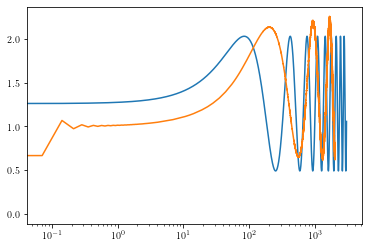

In [31]:
import matplotlib.pyplot as plt
plt.semilogx(geofs, geoFws)
plt.semilogx(ws, Fws)

In [49]:
ww = geofs

/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


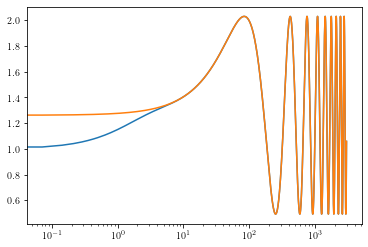

In [50]:
plt.semilogx(geofs, np.exp(-ww*np.pi/4) + (1-np.exp(-ww*np.pi/4))*geoFws)
plt.semilogx(geofs, geoFws)

In [ ]:
len(ws)